In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(555)
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score as rsq

mpl.rcParams['figure.figsize'] = (8, 6)

mpl.rcParams['axes.grid'] = False

def get_split_data(timeframe):
    train = pd.read_csv("data/"+timeframe+"_train.csv")
    validation = pd.read_csv("data/"+timeframe+"_validation.csv")
    test = pd.read_csv("data/"+timeframe+"_test.csv")
    return train, validation, test

def get_windowed_data(tempdf, wsize):
    f = []
    l = []
    for i in range(wsize, tempdf.shape[0]):
        window = tempdf.iloc[i-wsize:i, :]
        features = window.iloc[:, :-1].values
        labels = window.iloc[-1, -1]
        f.append(features)
        l.append(labels)

    f = np.array(f)
    l = np.array(l).reshape(len(l), 1)
    return f, l

def get_train_valid_test_x_y_data(timeframe):
    if timeframe == "hour":
        wsize = 12
    if timeframe == "minute":
        wsize = 30
    train, valid, test = get_split_data(timeframe)
    trainx, trainy = get_windowed_data(train, wsize)
    print("TRAIN: ", "x: ", trainx.shape, " y: ", trainy.shape)
    validx, validy = get_windowed_data(valid, wsize)
    print("VALID: ", "x: ", validx.shape, " y: ", validy.shape)
    testx, testy = get_windowed_data(test, wsize)
    print("TEST: ", "x: ", testx.shape, " y: ", testy.shape)
    
    return trainx, trainy, validx, validy, testx, testy

def build_lstm_model(input_data, output_size, neurons, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

def plot_errors(modelfit):
    plt.plot(modelfit.history['loss'],'r',linewidth=2, label='Training loss')
    plt.plot(modelfit.history['val_loss'], 'g',linewidth=2, label='Validation loss')
    plt.title('LSTM Neural Networks - XRP Model')
    plt.xlabel('Epochs numbers')
    plt.ylabel('MSE numbers')
    plt.legend()
    plt.show()
    
def analyze_predictions(model, testx, testy):
    preds = pd.DataFrame({"Prediction":model.predict(testx).squeeze(), "True": testy.squeeze()})
    print("MSE: ", mse(preds["True"], preds.Prediction))
    print("MAE: ", mae(preds["True"], preds.Prediction))
    print("MAPE: ",mape(preds["True"], preds.Prediction))
    print("R**2: ", rsq(preds["True"], preds.Prediction))
    preds.plot(figsize = (15, 7))
    
test_size = 0.2
zero_base = True
lstm_neurons = 50
epochs = 200
batch_size = 32
loss = 'mse'
dropout = 0.24
optimizer = 'adam'

# Hour

In [2]:
htrainx, htrainy, hvalidx, hvalidy, htestx, htesty = get_train_valid_test_x_y_data("hour")

TRAIN:  x:  (778, 12, 5)  y:  (778, 1)
VALID:  x:  (186, 12, 5)  y:  (186, 1)
TEST:  x:  (235, 12, 5)  y:  (235, 1)


In [3]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model = build_lstm_model(
    htrainx, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)

modelfit = model.fit(
    htrainx, htrainy, validation_data=(hvalidx, hvalidy), epochs=epochs, batch_size=batch_size, verbose=2, shuffle=True, callbacks = [es])

Metal device set to: Apple M1
Epoch 1/200


2022-05-19 00:01:29.942452: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-19 00:01:29.942535: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-05-19 00:01:30.063062: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-19 00:01:30.447833: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-19 00:01:30.560669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-19 00:01:30.633660: I tensorflow/core/grappler/o

25/25 - 1s - loss: 1.0001 - val_loss: 0.9652 - 1s/epoch - 45ms/step


2022-05-19 00:01:31.079757: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-19 00:01:31.120058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 2/200
25/25 - 0s - loss: 0.7286 - val_loss: 0.8456 - 280ms/epoch - 11ms/step
Epoch 3/200
25/25 - 0s - loss: 0.6697 - val_loss: 0.7608 - 280ms/epoch - 11ms/step
Epoch 4/200
25/25 - 0s - loss: 0.5741 - val_loss: 0.7296 - 280ms/epoch - 11ms/step
Epoch 5/200
25/25 - 0s - loss: 0.5476 - val_loss: 0.7148 - 282ms/epoch - 11ms/step
Epoch 6/200
25/25 - 0s - loss: 0.5431 - val_loss: 0.6813 - 277ms/epoch - 11ms/step
Epoch 7/200
25/25 - 0s - loss: 0.5156 - val_loss: 0.6671 - 281ms/epoch - 11ms/step
Epoch 8/200
25/25 - 0s - loss: 0.5058 - val_loss: 0.6558 - 277ms/epoch - 11ms/step
Epoch 9/200
25/25 - 0s - loss: 0.5125 - val_loss: 0.6481 - 278ms/epoch - 11ms/step
Epoch 10/200
25/25 - 0s - loss: 0.5021 - val_loss: 0.6419 - 278ms/epoch - 11ms/step
Epoch 11/200
25/25 - 0s - loss: 0.4968 - val_loss: 0.6393 - 279ms/epoch - 11ms/step
Epoch 12/200
25/25 - 0s - loss: 0.4864 - val_loss: 0.6338 - 277ms/epoch - 11ms/step
Epoch 13/200
25/25 - 0s - loss: 0.4849 - val_loss: 0.6273 - 281ms/epoch - 11ms/step


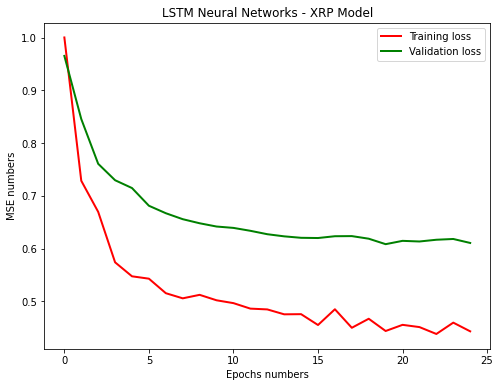

In [4]:
plot_errors(modelfit)

MSE:  0.6744978684700244
MAE:  0.5981543160484477
MAPE:  315849296265.85205
R**2:  -0.11923774561591771


2022-05-19 00:01:38.134246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-19 00:01:38.170301: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


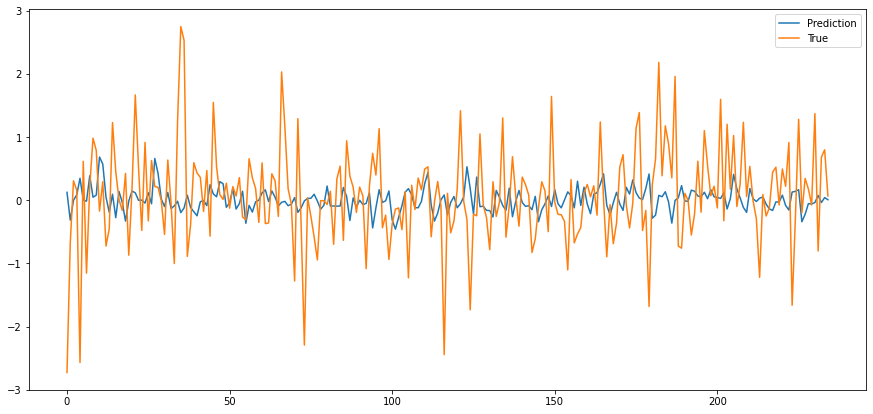

In [5]:
analyze_predictions(model, htestx, htesty)

# Minute

In [6]:
mtrainx, mtrainy, mvalidx, mvalidy, mtestx, mtesty = get_train_valid_test_x_y_data("minute")

TRAIN:  x:  (5842, 30, 5)  y:  (5842, 1)
VALID:  x:  (1438, 30, 5)  y:  (1438, 1)
TEST:  x:  (1805, 30, 5)  y:  (1805, 1)


In [7]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model = build_lstm_model(
    mtrainx, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)

modelfit = model.fit(
    mtrainx, mtrainy, validation_data=(mvalidx, mvalidy), epochs=epochs, batch_size=batch_size, verbose=2, shuffle=True, callbacks = [es])

Epoch 1/200


2022-05-19 00:02:39.278551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-19 00:02:39.389842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-19 00:02:39.562300: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-19 00:02:42.517419: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-19 00:02:42.557953: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


183/183 - 4s - loss: 0.0815 - val_loss: 0.0178 - 4s/epoch - 22ms/step
Epoch 2/200
183/183 - 3s - loss: 0.0258 - val_loss: 0.0136 - 3s/epoch - 16ms/step
Epoch 3/200
183/183 - 3s - loss: 0.0171 - val_loss: 0.0117 - 3s/epoch - 16ms/step
Epoch 4/200
183/183 - 3s - loss: 0.0133 - val_loss: 0.0113 - 3s/epoch - 17ms/step
Epoch 5/200
183/183 - 3s - loss: 0.0115 - val_loss: 0.0104 - 3s/epoch - 16ms/step
Epoch 6/200
183/183 - 3s - loss: 0.0102 - val_loss: 0.0094 - 3s/epoch - 16ms/step
Epoch 7/200
183/183 - 3s - loss: 0.0098 - val_loss: 0.0095 - 3s/epoch - 16ms/step
Epoch 8/200
183/183 - 3s - loss: 0.0093 - val_loss: 0.0095 - 3s/epoch - 16ms/step
Epoch 9/200
183/183 - 3s - loss: 0.0091 - val_loss: 0.0092 - 3s/epoch - 16ms/step
Epoch 10/200
183/183 - 3s - loss: 0.0091 - val_loss: 0.0093 - 3s/epoch - 16ms/step
Epoch 11/200
183/183 - 3s - loss: 0.0089 - val_loss: 0.0102 - 3s/epoch - 16ms/step
Epoch 12/200
183/183 - 3s - loss: 0.0088 - val_loss: 0.0093 - 3s/epoch - 16ms/step
Epoch 13/200
183/183 - 3s

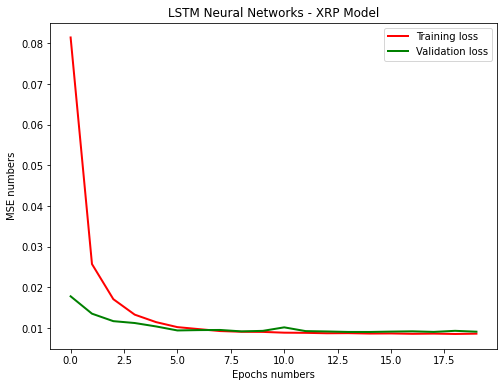

In [8]:
plot_errors(modelfit)

2022-05-19 00:03:39.422668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-19 00:03:39.459836: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


MSE:  0.010266161712524608
MAE:  0.0655030298427736
MAPE:  2099414527782.3792
R**2:  -0.014129117242955846


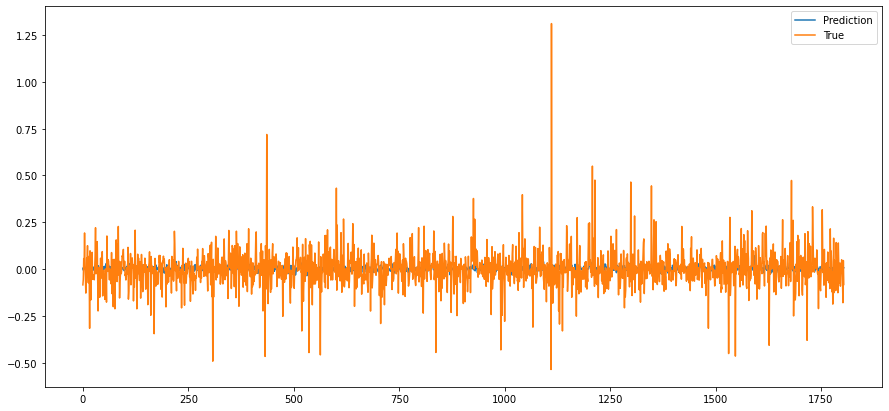

In [9]:
analyze_predictions(model, mtestx, mtesty)